In [1]:
# 1. Configuração do ambiente
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Evitar quebra de linha no print do DataFrame
pd.set_option('display.width', 0)  # ou use um valor grande como 2000
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)  # Impede quebra em várias linhas

# 2. Leitura do CSV (ajuste o caminho se necessário)
df = pd.read_csv("BRA.csv")

# Country: País onde ocorreu a partida (ex: Brazil)
# League: Nome da liga (ex: Serie A)
# Season: Ano da temporada (ex: 2012)
# Date: Data do jogo (formato dia/mês/ano)
# Time: Horário da partida (horário local, pode estar ausente em alguns jogos)
# Home: Nome do time mandante
# Away: Nome do time visitante
# HG: Gols marcados pelo time da casa (Home Goals)
# AG: Gols marcados pelo time visitante (Away Goals)
# Res: Resultado da partida (H = vitória do mandante, D = empate, A = vitória do visitante)

# PSCH, PSCD, PSCA: Odds de fechamento (closing odds) do mercado de apostas da Pinnacle para vitória do mandante (H), empate (D) e vitória do visitante (A)
# MaxCH, MaxCD, MaxCA: Maiores odds disponíveis entre as casas de apostas para H, D e A
# AvgCH, AvgCD, AvgCA: Odds médias do mercado para H, D e A

# BFECH, BFECD, BFECA: Odds do site Betfair Exchange para H, D e A (podem estar ausentes)

# 3. Visualização inicial
print(df.head())
print(" ")
print(df.info())
print(" ")
print(df.describe())

  Country   League  Season        Date   Time          Home         Away   HG   AG Res  PSCH  PSCD  PSCA  MaxCH  MaxCD  MaxCA  AvgCH  AvgCD  AvgCA  BFECH  BFECD  BFECA
0  Brazil  Serie A    2012  19/05/2012  22:30     Palmeiras   Portuguesa  1.0  1.0   D  1.75  3.86  5.25   1.76   3.87   5.31   1.69   3.50   4.90    NaN    NaN    NaN
1  Brazil  Serie A    2012  19/05/2012  22:30  Sport Recife  Flamengo RJ  1.0  1.0   D  2.83  3.39  2.68   2.83   3.42   2.70   2.59   3.23   2.58    NaN    NaN    NaN
2  Brazil  Serie A    2012  20/05/2012  01:00   Figueirense      Nautico  2.0  1.0   H  1.60  4.04  6.72   1.67   4.05   7.22   1.59   3.67   5.64    NaN    NaN    NaN
3  Brazil  Serie A    2012  20/05/2012  20:00   Botafogo RJ    Sao Paulo  4.0  2.0   H  2.49  3.35  3.15   2.49   3.39   3.15   2.35   3.26   2.84    NaN    NaN    NaN
4  Brazil  Serie A    2012  20/05/2012  20:00   Corinthians   Fluminense  0.0  1.0   A  1.96  3.53  4.41   1.96   3.53   4.41   1.89   3.33   3.89    NaN    NaN

In [2]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [3]:
df['Home'] = df['Home'].str.strip().str.title()
df['Away'] = df['Away'].str.strip().str.title()

In [4]:
df.drop(columns=["BFECH", "BFECD", "BFECA"], inplace=True)

In [5]:
print(df)

     Country   League  Season       Date   Time           Home         Away   HG   AG Res  PSCH  PSCD   PSCA  MaxCH  MaxCD  MaxCA  AvgCH  AvgCD  AvgCA
0     Brazil  Serie A    2012 2012-05-19  22:30      Palmeiras   Portuguesa  1.0  1.0   D  1.75  3.86   5.25   1.76   3.87   5.31   1.69   3.50   4.90
1     Brazil  Serie A    2012 2012-05-19  22:30   Sport Recife  Flamengo Rj  1.0  1.0   D  2.83  3.39   2.68   2.83   3.42   2.70   2.59   3.23   2.58
2     Brazil  Serie A    2012 2012-05-20  01:00    Figueirense      Nautico  2.0  1.0   H  1.60  4.04   6.72   1.67   4.05   7.22   1.59   3.67   5.64
3     Brazil  Serie A    2012 2012-05-20  20:00    Botafogo Rj    Sao Paulo  4.0  2.0   H  2.49  3.35   3.15   2.49   3.39   3.15   2.35   3.26   2.84
4     Brazil  Serie A    2012 2012-05-20  20:00    Corinthians   Fluminense  0.0  1.0   A  1.96  3.53   4.41   1.96   3.53   4.41   1.89   3.33   3.89
...      ...      ...     ...        ...    ...            ...          ...  ...  ...  ..   ..

In [6]:
# Padronização de Nomes de Times (Verificação)
print("\nNomes únicos de times da casa:")
print(df['Home'].unique())
print("\nNomes únicos de times visitantes:")
print(df['Away'].unique())


Nomes únicos de times da casa:
['Palmeiras' 'Sport Recife' 'Figueirense' 'Botafogo Rj' 'Corinthians'
 'Internacional' 'Ponte Preta' 'Bahia' 'Cruzeiro' 'Vasco' 'Atletico Go'
 'Flamengo Rj' 'Portuguesa' 'Nautico' 'Atletico-Mg' 'Coritiba' 'Santos'
 'Sao Paulo' 'Fluminense' 'Gremio' 'Vitoria' 'Criciuma' 'Athletico-Pr'
 'Goias' 'Chapecoense-Sc' 'Avai' 'Joinville' 'Santa Cruz' 'America Mg'
 'Parana' 'Ceara' 'Csa' 'Fortaleza' 'Bragantino' 'Cuiaba' 'Juventude'
 'Mirassol']

Nomes únicos de times visitantes:
['Portuguesa' 'Flamengo Rj' 'Nautico' 'Sao Paulo' 'Fluminense' 'Coritiba'
 'Atletico-Mg' 'Santos' 'Atletico Go' 'Gremio' 'Ponte Preta'
 'Internacional' 'Vasco' 'Cruzeiro' 'Corinthians' 'Botafogo Rj'
 'Sport Recife' 'Bahia' 'Figueirense' 'Palmeiras' 'Goias' 'Athletico-Pr'
 'Vitoria' 'Criciuma' 'Chapecoense-Sc' 'Joinville' 'Avai' 'Santa Cruz'
 'America Mg' 'Ceara' 'Parana' 'Csa' 'Fortaleza' 'Bragantino' 'Juventude'
 'Cuiaba' 'Mirassol']


In [7]:
missing = df.isnull().sum()
print(missing[missing > 0])

df_missing = df[df.isna().any(axis=1)]
print(df_missing)

df.dropna(subset=['HG', 'AG', 'AvgCH', 'AvgCD', 'AvgCA'], inplace=True)

HG      1
AG      1
Res     1
PSCH    1
PSCD    1
PSCA    1
dtype: int64
     Country   League  Season       Date   Time            Home         Away  HG  AG  Res  PSCH  PSCD  PSCA  MaxCH  MaxCD  MaxCA  AvgCH  AvgCD  AvgCA
1891  Brazil  Serie A    2016 2016-12-11  19:00  Chapecoense-Sc  Atletico-Mg NaN NaN  NaN   NaN   NaN   NaN   2.85    3.3   2.68   2.85    3.3   2.67


In [8]:
# 7. Colunas auxiliares
df["GoalDiff"] = df["HG"] - df["AG"]
df['Total_Goals'] = df['HG'] + df['AG']
df["is_home_win"] = df["Res"] == "H"
df["is_draw"] = df["Res"] == "D"
df["is_away_win"] = df["Res"] == "A"

In [9]:
df["ProbH"] = 1 / df["AvgCH"]
df["ProbD"] = 1 / df["AvgCD"]
df["ProbA"] = 1 / df["AvgCA"]

# Normalização das probabilidades
df["sum_probs"] = df["ProbH"] + df["ProbD"] + df["ProbA"]
df["ProbH"] /= df["sum_probs"]
df["ProbD"] /= df["sum_probs"]
df["ProbA"] /= df["sum_probs"]

df['Margin'] = df["sum_probs"] - 1

In [10]:
print(df)

     Country   League  Season       Date   Time           Home         Away   HG   AG Res  PSCH  PSCD   PSCA  MaxCH  MaxCD  MaxCA  AvgCH  AvgCD  AvgCA  GoalDiff  Total_Goals  is_home_win  is_draw  is_away_win     ProbH     ProbD     ProbA  sum_probs    Margin
0     Brazil  Serie A    2012 2012-05-19  22:30      Palmeiras   Portuguesa  1.0  1.0   D  1.75  3.86   5.25   1.76   3.87   5.31   1.69   3.50   4.90       0.0          2.0        False     True        False  0.547119  0.264180  0.188700   1.081512  0.081512
1     Brazil  Serie A    2012 2012-05-19  22:30   Sport Recife  Flamengo Rj  1.0  1.0   D  2.83  3.39   2.68   2.83   3.42   2.70   2.59   3.23   2.58       0.0          2.0        False     True        False  0.356413  0.285792  0.357794   1.083295  0.083295
2     Brazil  Serie A    2012 2012-05-20  01:00    Figueirense      Nautico  2.0  1.0   H  1.60  4.04   6.72   1.67   4.05   7.22   1.59   3.67   5.64       1.0          3.0         True    False        False  0.583037  

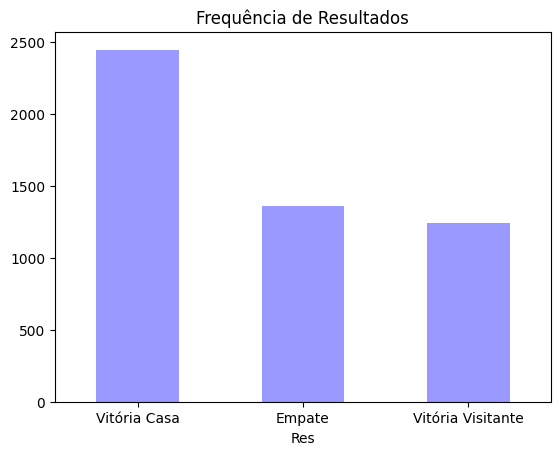

In [11]:
df['Res'].value_counts().plot(kind='bar', color='blue', alpha=0.4)
plt.title('Frequência de Resultados')
plt.xticks(ticks=[0, 1, 2], labels=['Vitória Casa', 'Empate', 'Vitória Visitante'], rotation=0)
plt.show()

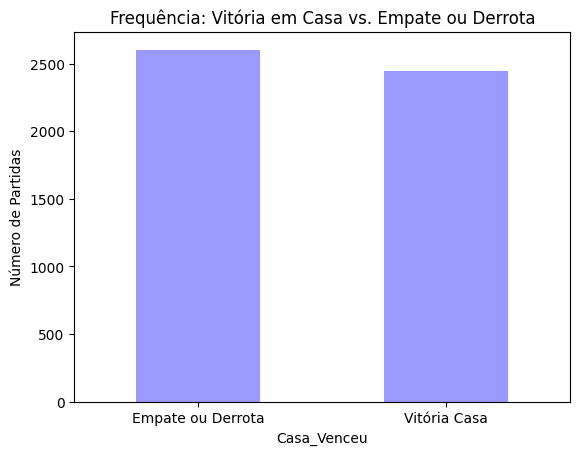

In [12]:
# Criar nova coluna categorizando o resultado
df["Casa_Venceu"] = df["Res"].apply(lambda x: "Vitória Casa" if x == "H" else "Empate ou Derrota")

# Contar e plotar
df["Casa_Venceu"].value_counts().plot(kind="bar", color="blue", alpha=0.4)
plt.title("Frequência: Vitória em Casa vs. Empate ou Derrota")
plt.xticks(rotation=0)
plt.ylabel("Número de Partidas")
plt.show()

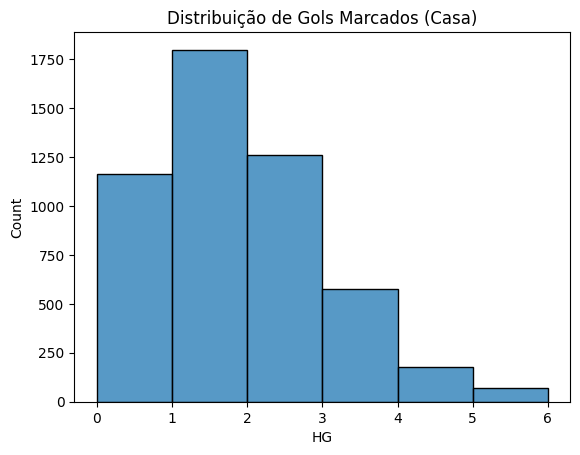

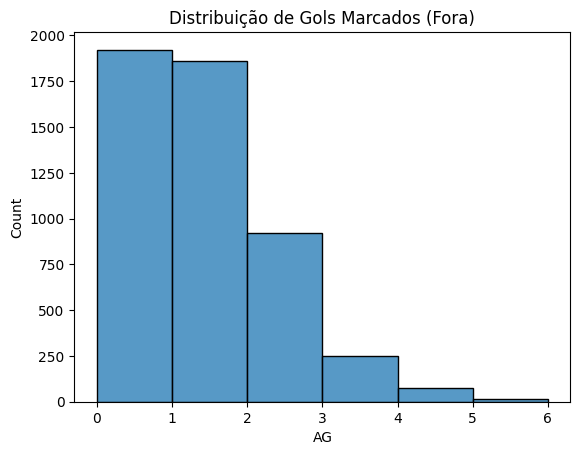

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['HG'], bins=range(0, 7), kde=False)
plt.title("Distribuição de Gols Marcados (Casa)")
plt.show()

sns.histplot(df['AG'], bins=range(0, 7), kde=False)
plt.title("Distribuição de Gols Marcados (Fora)")
plt.show()


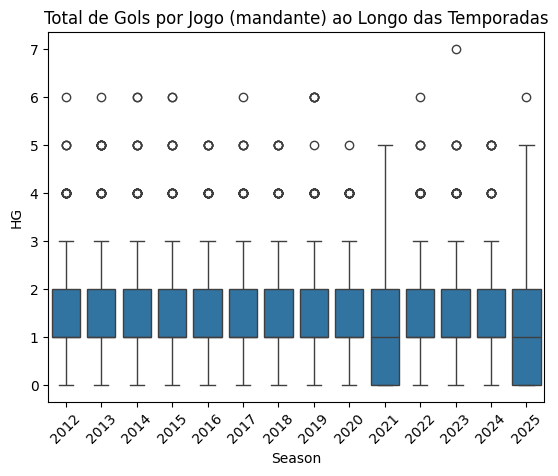

In [14]:
sns.boxplot(x='Season', y='HG', data=df)
plt.xticks(rotation=45)
plt.title("Total de Gols por Jogo (mandante) ao Longo das Temporadas")
plt.show()

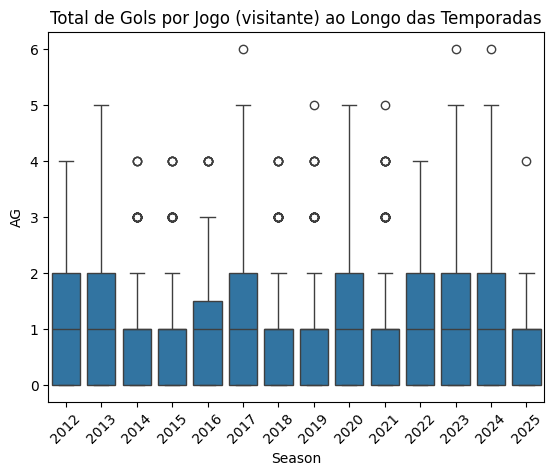

In [15]:
sns.boxplot(x='Season', y='AG', data=df)
plt.xticks(rotation=45)
plt.title("Total de Gols por Jogo (visitante) ao Longo das Temporadas")
plt.show()

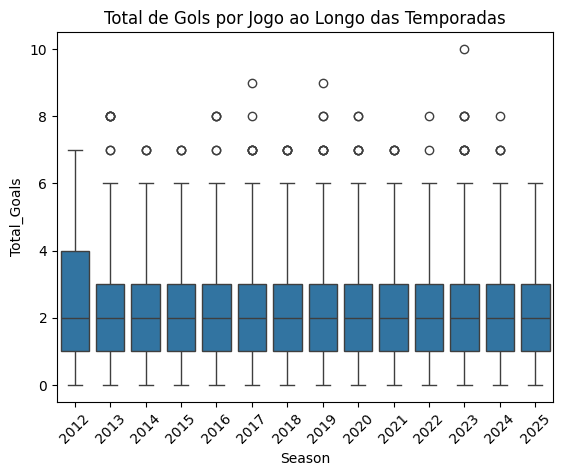

In [16]:
sns.boxplot(x='Season', y='Total_Goals', data=df)
plt.xticks(rotation=45)
plt.title("Total de Gols por Jogo ao Longo das Temporadas")
plt.show()

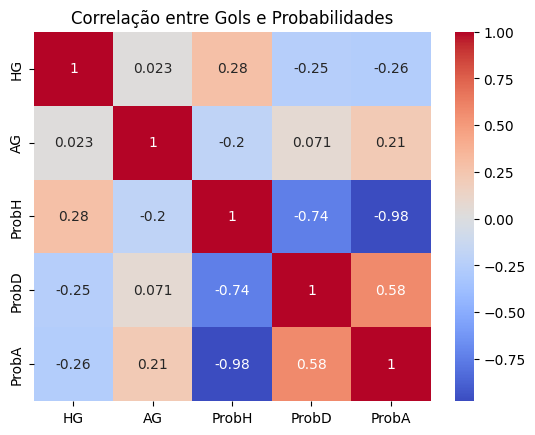

In [17]:
corr = df[['HG', 'AG', 'ProbH', 'ProbD', 'ProbA']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlação entre Gols e Probabilidades")
plt.show()

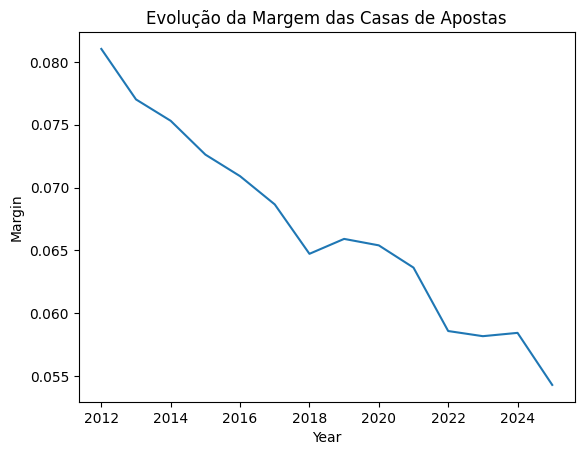

In [18]:
df['Year'] = df['Date'].dt.year
sns.lineplot(data=df.groupby('Year')['Margin'].mean().reset_index(), x='Year', y='Margin')
plt.title("Evolução da Margem das Casas de Apostas")
plt.show()

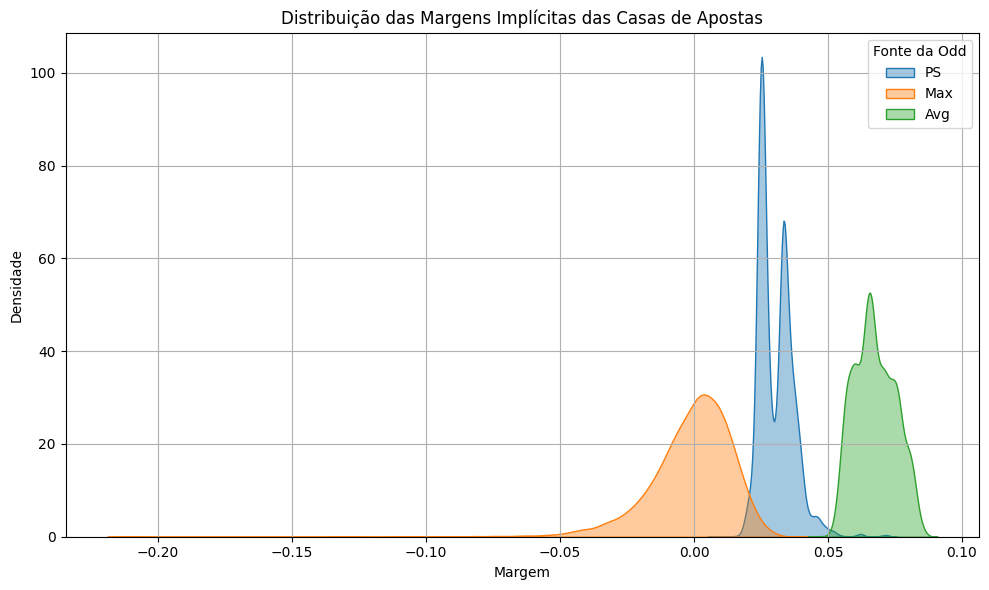

In [19]:
# Calcular margens implícitas para cada conjunto de odds
for prefix in ["PS", "Max", "Avg"]:
    df[f"{prefix}_H_Prob"] = 1 / df[f"{prefix}CH"]
    df[f"{prefix}_D_Prob"] = 1 / df[f"{prefix}CD"]
    df[f"{prefix}_A_Prob"] = 1 / df[f"{prefix}CA"]
    df[f"{prefix}_Sum"] = (
        df[f"{prefix}_H_Prob"] + df[f"{prefix}_D_Prob"] + df[f"{prefix}_A_Prob"]
    )
    df[f"{prefix}_Margin"] = df[f"{prefix}_Sum"] - 1

# Plotar as distribuições de margem
plt.figure(figsize=(10, 6))
for prefix in ["PS", "Max", "Avg"]:
    sns.kdeplot(
        df[f"{prefix}_Margin"], label=prefix, fill=True, alpha=0.4
    )
plt.title("Distribuição das Margens Implícitas das Casas de Apostas")
plt.xlabel("Margem")
plt.ylabel("Densidade")
plt.legend(title="Fonte da Odd")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Escolha um jogo com odds realistas (por exemplo, a 1ª linha)
linha = df.iloc[5039]

# PSCH  PSCD   PSCA

odd_home = linha["PSCH"]
odd_draw = linha["PSCD"]
odd_away = linha["PSCA"]

# Odds com overround (o que o público realmente recebe)
odds_com_spread = {"H": odd_home, "D": odd_draw, "A": odd_away}

# Cálculo das probabilidades implícitas
prob_H = 1 / odd_home
prob_D = 1 / odd_draw
prob_A = 1 / odd_away
soma_probs = prob_H + prob_D + prob_A

# Probabilidades normalizadas (como o público aposta)
probabilidades_normalizadas = {
    "H": prob_H / soma_probs,
    "D": prob_D / soma_probs,
    "A": prob_A / soma_probs
}

# Odds justas (sem overround)
odds_justas = {k: 1 / v for k, v in probabilidades_normalizadas.items()}

# Simulação
np.random.seed(42)
n_apostas = 1_000_000
stake = 1.0
apostas = np.random.choice(["H", "D", "A"], size=n_apostas, p=list(probabilidades_normalizadas.values()))

# Resultado real (pegando da coluna Res)
resultado_real = linha["Res"]

# Lucro da casa com odds COM spread
pagamento_com_spread = np.sum([
    stake * odds_com_spread[res] if res == resultado_real else 0
    for res in apostas
])
lucro_casa_com_spread = n_apostas * stake - pagamento_com_spread

# Lucro da casa com odds JUSTAS (para comparação)
pagamento_justo = np.sum([
    stake * odds_justas[res] if res == resultado_real else 0
    for res in apostas
])
lucro_casa_justa = n_apostas * stake - pagamento_justo

# Formatando os dicionários para remoção de np.float64
odds_com_spread_fmt = {k: round(float(v), 3) for k, v in odds_com_spread.items()}
odds_justas_fmt = {k: round(float(v), 3) for k, v in odds_justas.items()}
probs_fmt = {k: round(float(v), 4) for k, v in probabilidades_normalizadas.items()}

# Exibir resultados limpos
print(f"🎯 Jogo: {linha['Home']} x {linha['Away']} — Resultado real: {resultado_real}")
print(f"\nOdds com spread: {odds_com_spread_fmt}")
print(f"Odds justas (normalizadas): {odds_justas_fmt}")
print(f"\n🔢 Probabilidades implícitas normalizadas: {probs_fmt}")
print(f"\n💰 Lucro da casa com spread: R${lucro_casa_com_spread:,.2f}")
print(f"💸 Lucro da casa com odds justas: R${lucro_casa_justa:,.2f}")
print(f"\n📈 Diferença: R${(lucro_casa_com_spread - lucro_casa_justa):,.2f}")


🎯 Jogo: Vasco x Bragantino — Resultado real: A

Odds com spread: {'H': 2.46, 'D': 3.25, 'A': 3.13}
Odds justas (normalizadas): {'H': 2.543, 'D': 3.359, 'A': 3.235}

🔢 Probabilidades implícitas normalizadas: {'H': 0.3933, 'D': 0.2977, 'A': 0.3091}

💰 Lucro da casa com spread: R$32,091.32
💸 Lucro da casa com odds justas: R$-512.87

📈 Diferença: R$32,604.19


            OddsSpread  Avg_Margin
OddsSpread    1.000000   -0.056306
Avg_Margin   -0.056306    1.000000


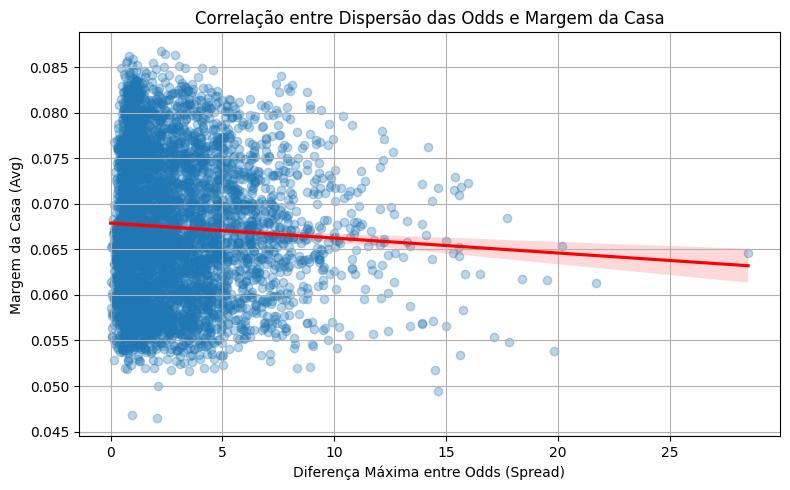

In [21]:
# Diferença entre maior e menor odd para cada linha (Avg odds) # PSCH  PSCD   PSCA
df["OddsSpread"] = df[["PSCH","PSCD","PSCA"]].max(axis=1) - df[["PSCH","PSCD","PSCA"]].min(axis=1)

# Correlação entre spread das odds e a margem da casa
correlation = df[["OddsSpread", "Avg_Margin"]].corr()
print(correlation)

# Visualização com linha de tendência linear
plt.figure(figsize=(8, 5))
sns.regplot(
    data=df,
    x="OddsSpread",
    y="Avg_Margin",
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "red"}
)
plt.title("Correlação entre Dispersão das Odds e Margem da Casa")
plt.xlabel("Diferença Máxima entre Odds (Spread)")
plt.ylabel("Margem da Casa (Avg)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Escolha um jogo com odds realistas (por exemplo, a 1ª linha)
linha = df.iloc[5039]

# PSCH  PSCD   PSCA

odd_home = linha["PSCH"]
odd_draw = linha["PSCD"]
odd_away = linha["PSCA"]

print(f"🎯 Jogo: {linha['Home']} x {linha['Away']} — Resultado real: {resultado_real}")

# Aposta unitária e número total de apostas
stake = 1.0
total_apostas = 1_000_000

# Probabilidades implícitas normalizadas
inv_probs = {
    "H": 1 / odd_home,
    "D": 1 / odd_draw,
    "A": 1 / odd_away
}
soma = sum(inv_probs.values())
prob_imp = {k: v / soma for k, v in inv_probs.items()}

# Mostrar as probabilidades implícitas
print("🎯 Probabilidades Implícitas Normalizadas:")
for k, v in prob_imp.items():
    print(f"  {k}: {v:.4f}")

# Criar cenários variando a preferência do público
cenarios = {
    "proporcional": [prob_imp["H"], prob_imp["D"], prob_imp["A"]],
    "enviesado_home": [prob_imp["H"] * 1.3, prob_imp["D"] * 0.85, prob_imp["A"] * 0.85],
    "enviesado_draw": [prob_imp["H"] * 0.85, prob_imp["D"] * 1.3, prob_imp["A"] * 0.85],
    "enviesado_away": [prob_imp["H"] * 0.85, prob_imp["D"] * 0.85, prob_imp["A"] * 1.3],
}

# Normalizar cada cenário
for k in cenarios:
    total = sum(cenarios[k])
    cenarios[k] = [x / total for x in cenarios[k]]

# Odds por resultado
odds = {"H": odd_home, "D": odd_draw, "A": odd_away}
resultados = ["H", "D", "A"]

# Simulação
def simular_lucro(distribuicao, resultado_real, odds):
    apostas = np.random.choice(["H", "D", "A"], size=total_apostas, p=distribuicao)
    odds_apostas = np.vectorize(odds.get)(apostas)
    ganhos = np.where(apostas == resultado_real, odds_apostas * stake, 0)
    lucro_casa = total_apostas * stake - ganhos.sum()
    return lucro_casa

# Executar simulações
for nome, dist in cenarios.items():
    print(f"\n📊 Cenário: {nome.replace('_', ' ').title()}")
    for resultado in resultados:
        lucro = simular_lucro(dist, resultado, odds)
        print(f"  Resultado real: {resultado} → Lucro da casa: R${lucro:,.2f}")


🎯 Jogo: Vasco x Bragantino — Resultado real: A
🎯 Probabilidades Implícitas Normalizadas:
  H: 0.3933
  D: 0.2977
  A: 0.3091

📊 Cenário: Proporcional
  Resultado real: H → Lucro da casa: R$30,194.20
  Resultado real: D → Lucro da casa: R$32,137.00
  Resultado real: A → Lucro da casa: R$32,094.45

📊 Cenário: Enviesado Home
  Resultado real: H → Lucro da casa: R$-225,180.86
  Resultado real: D → Lucro da casa: R$196,099.50
  Resultado real: A → Lucro da casa: R$198,263.02

📊 Cenário: Enviesado Draw
  Resultado real: H → Lucro da casa: R$164,111.68
  Resultado real: D → Lucro da casa: R$-277,792.75
  Resultado real: A → Lucro da casa: R$165,307.25

📊 Cenário: Enviesado Away
  Resultado real: H → Lucro da casa: R$168,820.12
  Resultado real: D → Lucro da casa: R$169,745.25
  Resultado real: A → Lucro da casa: R$-270,251.03


Total de partidas: 5048
  Odds_Faixa  Prob_Real  Prob_Normalizada  Num_Jogos
0    Faixa 1   0.714286          0.690686        511
1    Faixa 2   0.662136          0.607531        515
2    Faixa 3   0.555556          0.560425        522
3    Faixa 4   0.546414          0.518777        474
4    Faixa 5   0.507605          0.477768        526
5    Faixa 6   0.483034          0.440555        501
6    Faixa 7   0.450704          0.405292        497
7    Faixa 8   0.364919          0.368836        496
8    Faixa 9   0.341270          0.322907        504
9   Faixa 10   0.209163          0.238367        502


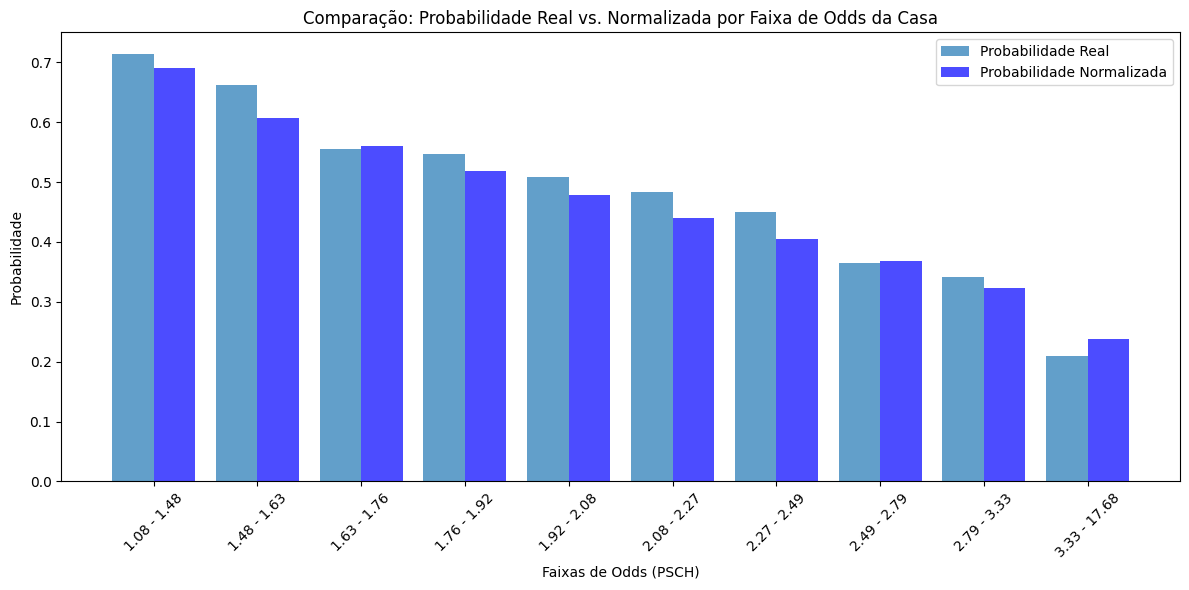

In [23]:
# Criar faixas de odds balanceadas usando PSCH (Odds da Casa)
df['Odds_Faixa'], bins = pd.qcut(df['PSCH'], q=10, retbins=True, labels=[f'Faixa {i+1}' for i in range(10)])

# Marcar vitória em casa como 1, outras como 0
df['Vitoria_Casa'] = (df['Res'] == 'H').astype(int)

# Calcular probabilidade real por faixa (frequência de vitórias em casa)
real_prob = df.groupby('Odds_Faixa', observed=True)['Vitoria_Casa'].mean()

# Calcular média da probabilidade normalizada por faixa
norm_prob = df.groupby('Odds_Faixa', observed=True)['ProbH'].mean()

counts = df.groupby('Odds_Faixa', observed=True).size()

# Criar DataFrame comparativo
comparacao_prob = pd.DataFrame({
    'Prob_Real': real_prob,
    'Prob_Normalizada': norm_prob,
    'Num_Jogos': counts
}).reset_index()

total_partidas = counts.sum()
print(f"Total de partidas: {total_partidas}")
print(comparacao_prob)


# Criar rótulos com os ranges das odds
ranges = [f"{bins[i]:.2f} - {bins[i+1]:.2f}" for i in range(len(bins) - 1)]
comparacao_prob['Odds_Range'] = ranges

# Plotando gráfico de barras lado a lado
plt.figure(figsize=(12, 6))
x = range(len(comparacao_prob))

plt.bar(x, comparacao_prob['Prob_Real'], width=0.4, label='Probabilidade Real', alpha=0.7)
plt.bar([p + 0.4 for p in x], comparacao_prob['Prob_Normalizada'], width=0.4, label='Probabilidade Normalizada', color='blue', alpha=0.7)

# Ajustar eixo X com os ranges de odds
plt.xticks([p + 0.2 for p in x], comparacao_prob['Odds_Range'], rotation=45)
plt.xlabel('Faixas de Odds (PSCH)')
plt.ylabel('Probabilidade')
plt.title('Comparação: Probabilidade Real vs. Normalizada por Faixa de Odds da Casa')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# Identificar faixas de value bet
faixas_valor = comparacao_prob[
    comparacao_prob["Prob_Real"] > comparacao_prob["Prob_Normalizada"]
]["Odds_Faixa"].tolist()

print(faixas_valor)

['Faixa 1', 'Faixa 2', 'Faixa 4', 'Faixa 5', 'Faixa 6', 'Faixa 7', 'Faixa 9']


In [25]:
# Simular apostas apenas nos jogos onde a PSCH cai nas faixas de valor
df["Aposta_Casa"] = df["Odds_Faixa"].isin(faixas_valor)
df["Lucro"] = 0.0
df.loc[df["Aposta_Casa"] & (df["Res"] == "H"), "Lucro"] = df["PSCH"] - 1
df.loc[df["Aposta_Casa"] & (df["Res"] != "H"), "Lucro"] = -1

# Avaliar desempenho
total_apostas = df["Aposta_Casa"].sum()
lucro_total = df["Lucro"].sum()
roi = lucro_total / total_apostas if total_apostas > 0 else 0

print(f"Apostas simuladas: {total_apostas}")
print(f"Lucro total: {lucro_total:.2f}")
print(f"ROI: {roi:.2%}")

Apostas simuladas: 3528
Lucro total: 101.05
ROI: 2.86%


In [26]:
# Dados até 2024 para calibrar a estratégia
df_treino = df[df["Season"] <= 2024].dropna(subset=["PSCH", "ProbH", "Res"]).copy()

# Dados de 2025 para testar a estratégia
df_teste = df[df["Season"] == 2025].dropna(subset=["PSCH", "ProbH", "Res"]).copy()

In [27]:
# Faixas de odds com PSCH (apenas no treino)
df_treino["Odds_Faixa"], bins = pd.qcut(
    df_treino["PSCH"], q=10, retbins=True, labels=[f"Faixa {i+1}" for i in range(10)]
)

# Marcar vitórias da casa
df_treino["Vitoria_Casa"] = (df_treino["Res"] == "H").astype(int)

# Probabilidades reais e normalizadas por faixa
real_prob = df_treino.groupby("Odds_Faixa", observed=True)["Vitoria_Casa"].mean()
norm_prob = df_treino.groupby("Odds_Faixa", observed=True)["ProbH"].mean()

counts = df_treino.groupby('Odds_Faixa', observed=True).size()

total_partidas = counts.sum()
print(f"Total de partidas: {total_partidas}")

# Criar DataFrame comparativo
comparacao_prob = pd.DataFrame({
    'Prob_Real': real_prob,
    'Prob_Normalizada': norm_prob,
    'Num_Jogos': counts
}).reset_index()

# Adicionar os ranges
ranges = [f"{bins[i]:.2f} - {bins[i+1]:.2f}" for i in range(len(bins) - 1)]
comparacao_prob["Odds_Range"] = ranges

print(comparacao_prob)

Total de partidas: 4939
  Odds_Faixa  Prob_Real  Prob_Normalizada  Num_Jogos    Odds_Range
0    Faixa 1   0.710317          0.690688        504   1.08 - 1.48
1    Faixa 2   0.663386          0.607556        508   1.48 - 1.63
2    Faixa 3   0.554622          0.561639        476   1.63 - 1.75
3    Faixa 4   0.549696          0.520454        493   1.75 - 1.92
4    Faixa 5   0.505792          0.477710        518   1.92 - 2.08
5    Faixa 6   0.481481          0.440656        486   2.08 - 2.27
6    Faixa 7   0.446985          0.405310        481   2.27 - 2.49
7    Faixa 8   0.364198          0.368794        486   2.49 - 2.79
8    Faixa 9   0.339394          0.323064        495   2.79 - 3.33
9   Faixa 10   0.211382          0.238854        492  3.33 - 17.68


In [28]:
# Identificar faixas de value bet
faixas_valor = comparacao_prob[
    comparacao_prob["Prob_Real"] > comparacao_prob["Prob_Normalizada"]
]["Odds_Faixa"].tolist()

print(faixas_valor)

['Faixa 1', 'Faixa 2', 'Faixa 4', 'Faixa 5', 'Faixa 6', 'Faixa 7', 'Faixa 9']


In [29]:
# Reusar os mesmos bins para rotular os dados de 2025
df_teste["Odds_Faixa"] = pd.cut(df_teste["PSCH"], bins=bins, labels=[f"Faixa {i+1}" for i in range(10)])

# Marcar onde apostar
df_teste["Aposta_Casa"] = df_teste["Odds_Faixa"].isin(faixas_valor)

# Calcular lucro
df_teste["Lucro"] = 0.0
df_teste.loc[df_teste["Aposta_Casa"] & (df_teste["Res"] == "H"), "Lucro"] = df_teste["PSCH"] - 1
df_teste.loc[df_teste["Aposta_Casa"] & (df_teste["Res"] != "H"), "Lucro"] = -1

# Avaliação
total_apostas = df_teste["Aposta_Casa"].sum()
lucro_total = df_teste["Lucro"].sum()
roi = lucro_total / total_apostas if total_apostas > 0 else 0

print(f"Apostas simuladas em 2025: {total_apostas}")
print(f"Lucro total: {lucro_total:.2f}")
print(f"ROI: {roi:.2%}")

Apostas simuladas em 2025: 80
Lucro total: 16.95
ROI: 21.19%


In [30]:
# Filtrar apenas as apostas realizadas
df_apostas = df_teste[df_teste["Aposta_Casa"]].copy()

# Agrupar por faixa
resultado_por_faixa = df_apostas.groupby("Odds_Faixa", observed=True).agg(
    Total_Apostas=("Aposta_Casa", "sum"),
    Lucro_Total=("Lucro", "sum"),
    Media_Odd=("PSCH", "mean")
)

# Calcular ROI por faixa
resultado_por_faixa["ROI"] = resultado_por_faixa["Lucro_Total"] / resultado_por_faixa["Total_Apostas"]

# Resetar índice para exibir como tabela
resultado_por_faixa = resultado_por_faixa.reset_index()

# Exibir
print(resultado_por_faixa)

  Odds_Faixa  Total_Apostas  Lucro_Total  Media_Odd       ROI
0    Faixa 1              7         2.67   1.381429  0.381429
1    Faixa 2              7        -0.61   1.575714 -0.087143
2    Faixa 4             18         2.03   1.823889  0.112778
3    Faixa 5              8         1.82   1.985000  0.227500
4    Faixa 6             15         2.67   2.208000  0.178000
5    Faixa 7             16         5.30   2.383125  0.331250
6    Faixa 9              9         3.07   3.070000  0.341111


In [31]:
# Soma dos lucros e apostas por faixa
lucro_somado = resultado_por_faixa["Lucro_Total"].sum()
apostas_somadas = resultado_por_faixa["Total_Apostas"].sum()
roi_somado = lucro_somado / apostas_somadas if apostas_somadas > 0 else 0

# Comparar com o resultado total
print("=== Verificação de consistência ===")
print(f"Lucro total (somado por faixa): {lucro_somado:.2f}  |  Lucro total direto: {lucro_total:.2f}")
print(f"Apostas totais (somadas): {apostas_somadas}  |  Apostas totais direto: {total_apostas}")
print(f"ROI (calculado por faixa): {roi_somado:.2%}  |  ROI direto: {roi:.2%}")

=== Verificação de consistência ===
Lucro total (somado por faixa): 16.95  |  Lucro total direto: 16.95
Apostas totais (somadas): 80  |  Apostas totais direto: 80
ROI (calculado por faixa): 21.19%  |  ROI direto: 21.19%
